In [1]:
# Imports and configurations
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from ipywidgets import widgets
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
from ipywidgets import Checkbox, IntSlider

import matplotlib as mpl
import pickle

from mklib import plist 

import sc2reader
from sc2reader.engine.plugins import APMTracker, SelectionTracker
sc2reader.engine.register_plugin(APMTracker())
sc2reader.engine.register_plugin(SelectionTracker())

In [2]:
path_to_games = '../data/replay/'
example_gamefile = path_to_games + 'Learn From Pros 8 - Maru 2-1-1.SC2Replay'
replay = sc2reader.load_replay(example_gamefile)
type(replay)

sc2reader.resources.Replay

In [3]:
def frames_to_irl_seconds(num): 
    return (num/16) / 1.4

def irl_seconds_to_frames(num): 
    return num * 16 * 1.4

def getUnits(units = [], time = False,
             finished_before = np.inf, finished_after = 0,
             died_before = np.inf, died_after = 0, 
             army = True, workers = True, buildings = True,
             player = None, name = None,replay = None):
    
    if type(time) != bool:
        died_after = time+1
        finished_before = time
    
    died_before = irl_seconds_to_frames(died_before)
    died_after = irl_seconds_to_frames(died_after)
    finished_before = irl_seconds_to_frames(finished_before)
    finished_after = irl_seconds_to_frames(finished_after)

    if player != None:
        units = player.units
    elif units == []:
        units = replay.players[0].units + replay.players[1].units
    else:
        units = units
        
    return [unit for unit in units 
            if (unit.finished_at != None and 
                unit.finished_at <= finished_before
                and unit.finished_at >= finished_after)
            
            and (unit.died_at == None 
                 or unit.died_at >= died_after)
    
            and (died_before == np.inf or (unit.died_at != None
                 and unit.died_at <= died_before))
            
            and ((unit.is_army and army) 
                 or (unit.is_worker and workers)
                 or (unit.is_building and buildings))
            
            and (name == None or name in unit.name)]

In [4]:
def getXY(iterable):
    return [[obj[0] for obj in iterable],[obj[1] for obj in iterable]]

def getLocations(units):
    return [unit.location for unit in units]

def getUnitType(units = [], name = ''):
    return [unit for unit in units if name in unit.name]

def plotGameState(replay = None,
                 time = 0,
                 minerals = True,
                 vespene = True,
                 towers = True,
                 workers = True,
                 army = True,
                 buildings = True,
                 ramps = True,
                 kwargs = {}):
    
    kwargs['time'] = time
    
    all_units = list(replay.active_units.values())
    p1 = replay.players[0]
    p2 = replay.players[1]
    
    terran_colors = ['#0703d4','#e31a00']
    zerg_colors   = ['#a01cd9','#e00283']
    protos_colors = ['e6cf00', '#e89b00']

    classic_colors = {'Terran':terran_colors, 
                      'Zerg':zerg_colors, 
                      'Protoss':protos_colors}

    p1c = classic_colors[replay.players[0].play_race][0]
    p2c = classic_colors[replay.players[1].play_race][1]

        
    if minerals:
        mineralfields = getXY(getLocations(getUnitType(all_units, name = 'MineralField')))
        plt.scatter(mineralfields[0], mineralfields[1], color = '#44a7f2', alpha=1)
    
    if vespene:
        vespenegeyser = getXY(getLocations(getUnitType(all_units, name = 'VespeneGeyser')))
        plt.scatter(vespenegeyser[0], vespenegeyser[1], color = '#3ed121', alpha=1)
        
    if towers:  
        xelnagatowers = getXY(getLocations(getUnitType(all_units, name = 'XelNagaTower')))
        plt.scatter(xelnagatowers[0], xelnagatowers[1], color = 'k', alpha=0.5)
        
    if ramps:
        destructibleramp = getXY(getLocations(getUnitType(all_units, name = 'Destructible')))
        plt.scatter(destructibleramp[0], destructibleramp[1], color = 'orange', alpha=0.5, s = 100, marker='s')
        
    if workers:
        p1workers = getXY(getLocations(getUnits(player=p1,workers=True, army = False, buildings = False, **kwargs)))
        p2workers = getXY(getLocations(getUnits(player=p2,workers=True, army = False, buildings = False, **kwargs)))

        plt.scatter(p1workers[0], p1workers[1], color = p1c, s = 10)
        plt.scatter(p2workers[0], p2workers[1], color = p2c, s = 10)
        
    if army:
        p1army = getXY(getLocations(getUnits(player=p1,workers=False, army = True, buildings = False, **kwargs)))
        p2army = getXY(getLocations(getUnits(player=p2,workers=False, army = True, buildings = False, **kwargs)))

        plt.scatter(p1army[0], p1army[1], color = p1c, s = 10, marker='*', alpha=0.5)
        plt.scatter(p2army[0], p2army[1], color = p2c, s = 10, marker='*', alpha=0.5)
        
    if buildings:
        p1buildings = getXY(getLocations(getUnits(player=p1,workers=False, army = False, buildings = True, **kwargs)))
        p2buildings = getXY(getLocations(getUnits(player=p2,workers=False, army = False, buildings = True, **kwargs)))

        plt.scatter(p1buildings[0], p1buildings[1], c = p1c, s = 100, marker='s', alpha=0.5)
        plt.scatter(p2buildings[0], p2buildings[1], c = p2c, s = 100, marker='s', alpha=0.5)
        
    minx = min(mineralfields[0]) - 20
    maxx = max(mineralfields[0]) + 20
    miny = min(mineralfields[1]) - 20
    maxy = max(mineralfields[1]) + 20
    plt.xlim([minx,maxx])
    plt.ylim([miny,maxy])

    plt.title('Map: ' + current_game.map_name + '\n'
              + 'Players: ' + current_game.players[0].name + ' / ' + current_game.players[1].name)
    # plt.show()

def plwrap(time = 0, **kwargs):
    plotGameState(time=time, replay=current_game, **kwargs)
    return None

def plot_replay_of_current_game():
    current_game = replay

    interact(plwrap, time=IntSlider(min=0, max=frames_to_irl_seconds(replay.frames), step=1))
    return None

In [5]:
def plotGameState2(replay = None,
                 time = 0,
                 minerals = True,
                 vespene = True,
                 towers = True,
                 workers = True,
                 army = True,
                 buildings = True,
                 ramps = True,
                 kwargs = {},
                 num = 0):
    
    kwargs['time'] = time
    
    all_units = list(replay.active_units.values())
    p1 = replay.players[0]
    p2 = replay.players[1]
    
    terran_colors = ['#0703d4','#e31a00']
    zerg_colors   = ['#a01cd9','#e00283']
    protos_colors = ['e6cf00', '#e89b00']

    classic_colors = {'Terran':terran_colors, 
                      'Zerg':zerg_colors, 
                      'Protoss':protos_colors}

    p1c = classic_colors[replay.players[0].play_race][0]
    p2c = classic_colors[replay.players[1].play_race][1]

    
    plt.subplot(6, 6, num)
    
    if minerals:
        mineralfields = getXY(getLocations(getUnitType(all_units, name = 'MineralField')))
        plt.scatter(mineralfields[0], mineralfields[1], color = '#44a7f2', alpha=1)
    
    if vespene:
        vespenegeyser = getXY(getLocations(getUnitType(all_units, name = 'VespeneGeyser')))
        plt.scatter(vespenegeyser[0], vespenegeyser[1], color = '#3ed121', alpha=1)
        
    if towers:  
        xelnagatowers = getXY(getLocations(getUnitType(all_units, name = 'XelNagaTower')))
        plt.scatter(xelnagatowers[0], xelnagatowers[1], color = 'k', alpha=0.5)
        
    if ramps:
        destructibleramp = getXY(getLocations(getUnitType(all_units, name = 'Destructible')))
        plt.scatter(destructibleramp[0], destructibleramp[1], color = 'orange', alpha=0.5, s = 100, marker='s')
        
    if workers:
        p1workers = getXY(getLocations(getUnits(player=p1,workers=True, army = False, buildings = False, **kwargs)))
        p2workers = getXY(getLocations(getUnits(player=p2,workers=True, army = False, buildings = False, **kwargs)))

        plt.scatter(p1workers[0], p1workers[1], color = p1c, s = 10)
        plt.scatter(p2workers[0], p2workers[1], color = p2c, s = 10)
        
    if army:
        p1army = getXY(getLocations(getUnits(player=p1,workers=False, army = True, buildings = False, **kwargs)))
        p2army = getXY(getLocations(getUnits(player=p2,workers=False, army = True, buildings = False, **kwargs)))

        plt.scatter(p1army[0], p1army[1], color = p1c, s = 10, marker='*', alpha=0.5)
        plt.scatter(p2army[0], p2army[1], color = p2c, s = 10, marker='*', alpha=0.5)
        
    if buildings:
        p1buildings = getXY(getLocations(getUnits(player=p1,workers=False, army = False, buildings = True, **kwargs)))
        p2buildings = getXY(getLocations(getUnits(player=p2,workers=False, army = False, buildings = True, **kwargs)))

        plt.scatter(p1buildings[0], p1buildings[1], c = p1c, s = 100, marker='s', alpha=0.5)
        plt.scatter(p2buildings[0], p2buildings[1], c = p2c, s = 100, marker='s', alpha=0.5)
        
    minx = min(mineralfields[0]) - 20
    maxx = max(mineralfields[0]) + 20
    miny = min(mineralfields[1]) - 20
    maxy = max(mineralfields[1]) + 20
    plt.xlim([minx,maxx])
    plt.ylim([miny,maxy])

    # plt.title('Map: ' + current_game.map_name + '\n'
    #           + 'Players: ' + current_game.players[0].name + ' / ' + current_game.players[1].name + '\n'
    #           + 'Time: ' + str(time))
    plt.title('Time: ' + str(time))
    # plt.show()

def plwrap2(time = 0, **kwargs):
    plotGameState2(time=time, replay=current_game, **kwargs)
    return None

def plot_replay_of_game_interval(replay):
  i, count = 0, 1
  plt.figure(figsize=(20,20))
  while i <= frames_to_irl_seconds(replay.frames):
    
    # plt.subplot(4,4, count+1)
    plotGameState2(time=i, replay=current_game, num=count)
    # plwrap2(time=i)
        # units = get_end_location_of_units(game).sort_values(by='owner')
        # plt.scatter(units['x'], units['y'], c=units['owner'], alpha = 0.4)
        # if optional_indexes is None:
        #     plt.title('Game {}: '.format(str(i))+['Purple','Yellow'][game['outcome']['Win']-1] + ' Won')
        # else:
        #     plt.title('Game {}: '.format(optional_indexes[i])+['Purple','Yellow'][game['outcome']['Win']-1] + ' Won')
    plt.tight_layout(pad=1)
    i += 30
    count += 1
  plt.show()

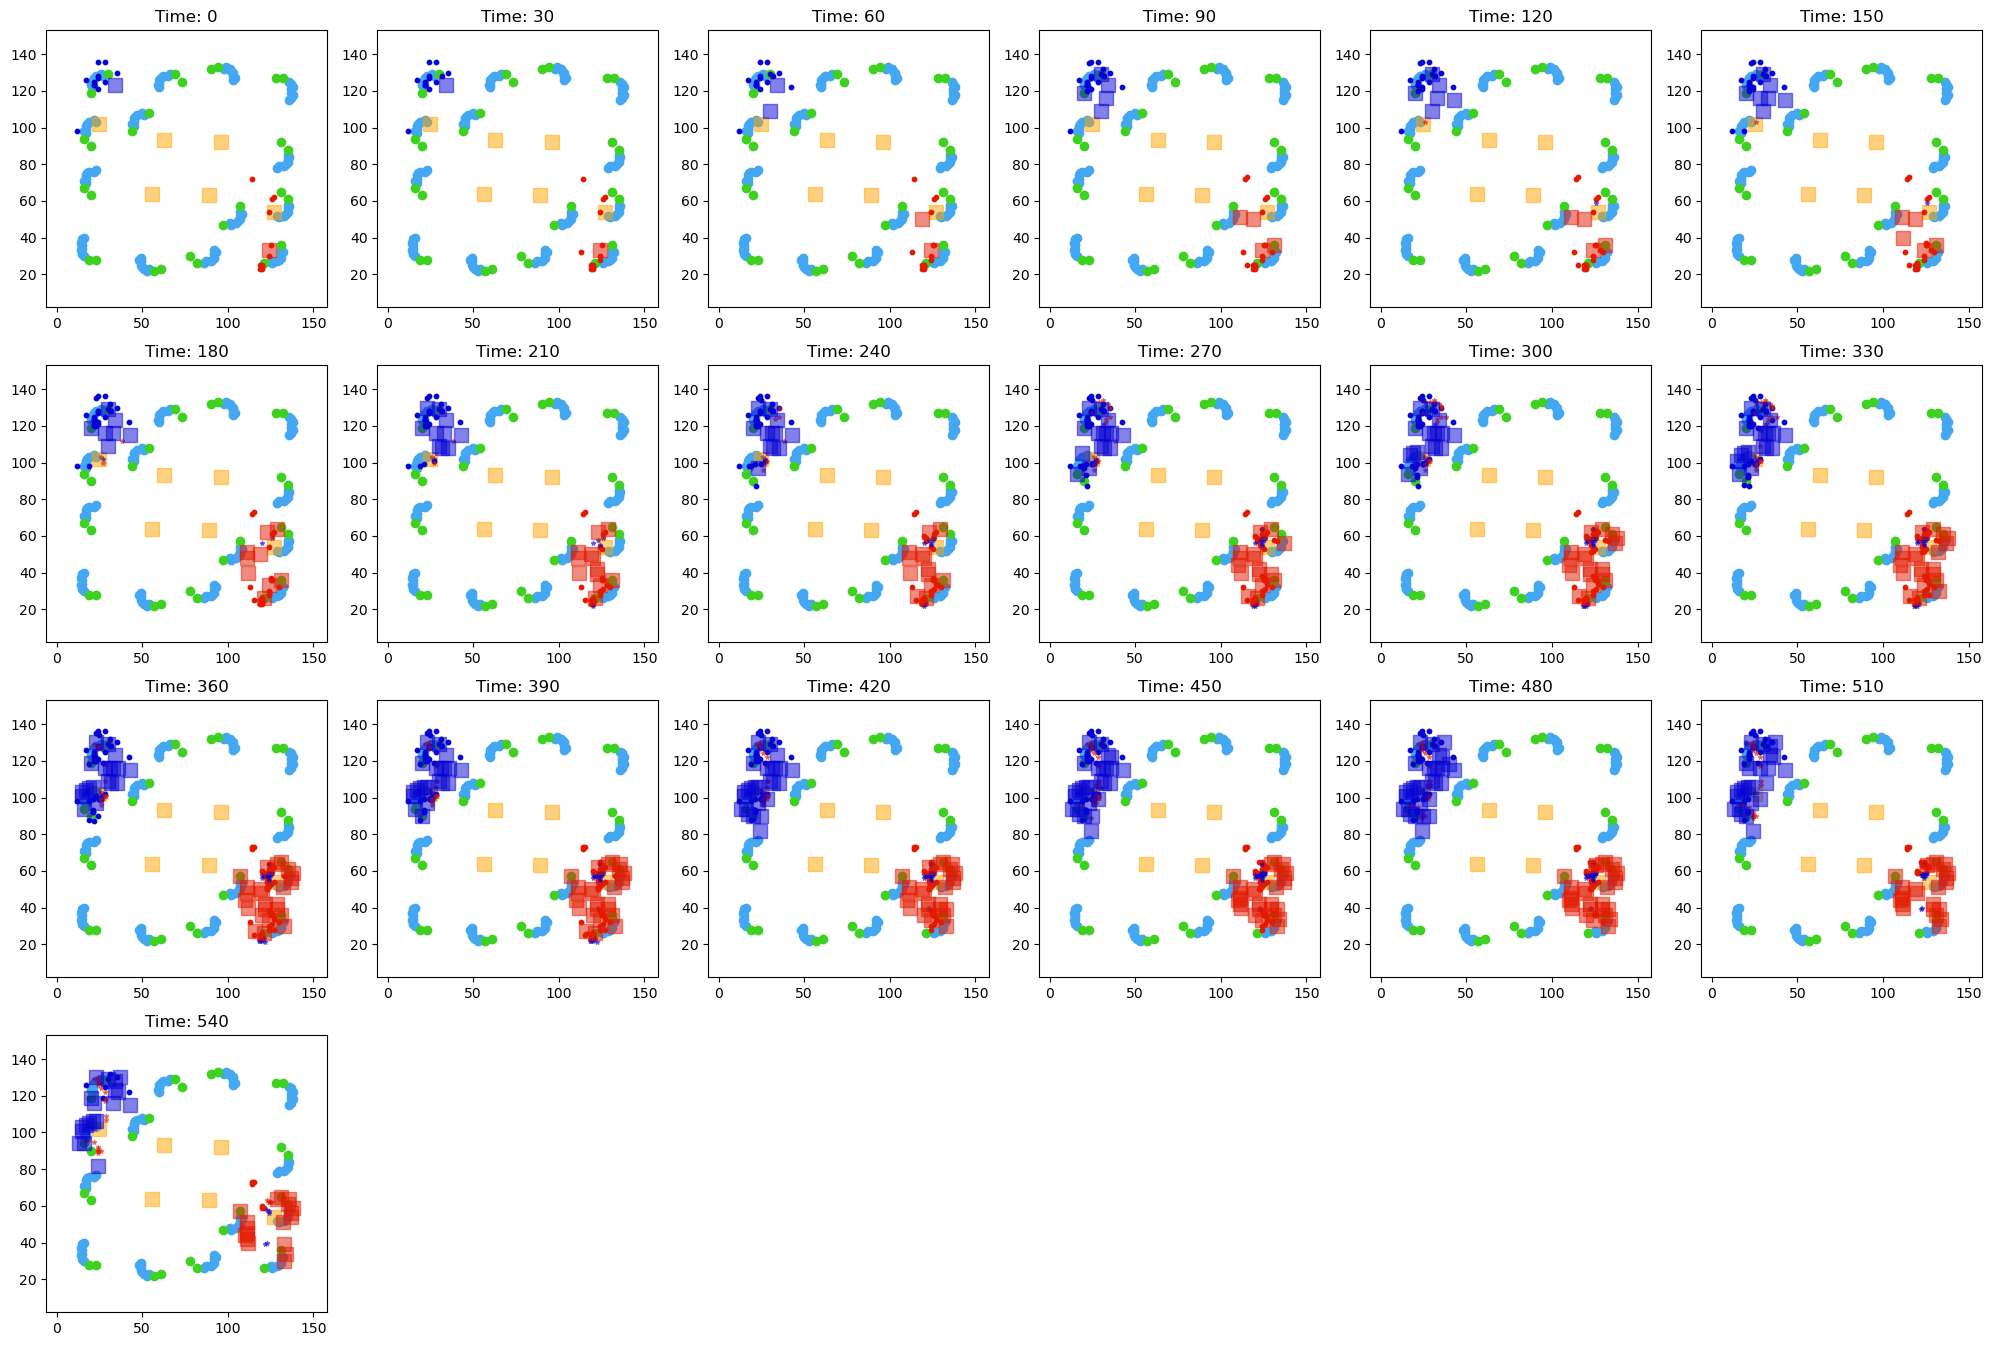

In [6]:
current_game = replay
# plot_replay_of_current_game()
plot_replay_of_game_interval(current_game)

In [7]:
def plot_game_end_states(games, optional_indexes = None):
    '''given a corpus of replay files it will plot 
    the end location of units for the first 16 games'''
    if optional_indexes is None:
        games = games[0:min(16, len(games))]
    else: 
        games = [games[i] for i in optional_indexes]
        
    games = [preliminary_processing(game) for game in games]
    plt.figure(figsize=(20,10))
    for i,game in enumerate(games):
        plt.subplot(4,4, i+1)
        units = get_end_location_of_units(game).sort_values(by='owner')
        plt.scatter(units['x'], units['y'], c=units['owner'], alpha = 0.4)
        if optional_indexes is None:
            plt.title('Game {}: '.format(str(i))+['Purple','Yellow'][game['outcome']['Win']-1] + ' Won')
        else:
            plt.title('Game {}: '.format(optional_indexes[i])+['Purple','Yellow'][game['outcome']['Win']-1] + ' Won')
    plt.tight_layout(pad=1)
    plt.show()